In [2]:
import sys, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

In [3]:
from src.dataset import build_dataset
from src.modeling import train_test_split_time
from src.config import TARGET_COL, FEATURE_COLS

# IMPORTANT: on active toutes les données externes
df_feat = build_dataset(
    include_vix=True,
    include_rates=True,
    include_usd_index=True,
    include_sp500=True,
).sort_values("date").reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print("df_feat shape:", df_feat.shape)
print("Période:", df_feat["date"].min().date(), "→", df_feat["date"].max().date())
print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Target balance:", df_feat[TARGET_COL].value_counts(normalize=True).round(3))

# petit check: on voit bien les features
df_feat[["date", "close"] + FEATURE_COLS].tail(3)


df_feat shape: (1250, 38)
Période: 2020-12-23 → 2025-10-23
Train size: 1000 | Test size: 250
Target balance: y_up
0    0.503
1    0.497
Name: proportion, dtype: float64


,date,close,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_rollmean_5,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,...,rsi_14,macd_hist,dow_sin,dow_cos,vix_lag1,dgs2_lag1,dgs10_lag1,term_spread_lag1,dtwexbgs_ret_lag1,sp500_ret_lag1
1247,2025-10-21,1.16050,-0.002219,-0.001514,0.003822,0.003128,-0.000051,0.003281,0.003593,0.003541,...,37.275986,-0.000364,0.781831,0.623490,18.23,3.46,4.00,0.54,-0.000680,0.010672
1248,2025-10-22,1.16128,-0.003426,-0.002219,-0.001514,0.003084,-0.000533,0.002855,0.003535,0.003312,...,39.370079,-0.000383,0.974928,-0.222521,17.87,3.45,3.98,0.53,0.002170,0.000033
1249,2025-10-23,1.15958,0.000672,-0.003426,-0.002219,0.003822,-0.001590,0.001492,0.003054,0.002995,...,35.125741,-0.000465,0.433884,-0.900969,18.60,3.45,3.97,0.52,0.000045,-0.005338


In [4]:
import xgboost as xgb
from src.evaluation import evaluate_classifier

# XGBoost = arbres boostés (souvent efficace sur données tabulaires)
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=0,
)

xgb_model.fit(X_train, y_train)
evaluate_classifier(xgb_model, X_train, y_train, X_test, y_test, name="XGBoost (advanced, ext data)")


=== XGBoost (advanced, ext data) ===
Accuracy: 0.484
ROC-AUC : 0.487
Confusion matrix:
 [[68 59]
 [70 53]]

Classification report:
               precision    recall  f1-score   support

           0      0.493     0.535     0.513       127
           1      0.473     0.431     0.451       123

    accuracy                          0.484       250
   macro avg      0.483     0.483     0.482       250
weighted avg      0.483     0.484     0.483       250



(0.484, 0.4874847961078036)

Brier score XGB (uncal): 0.2932
Brier score XGB (cal)  : 0.2591


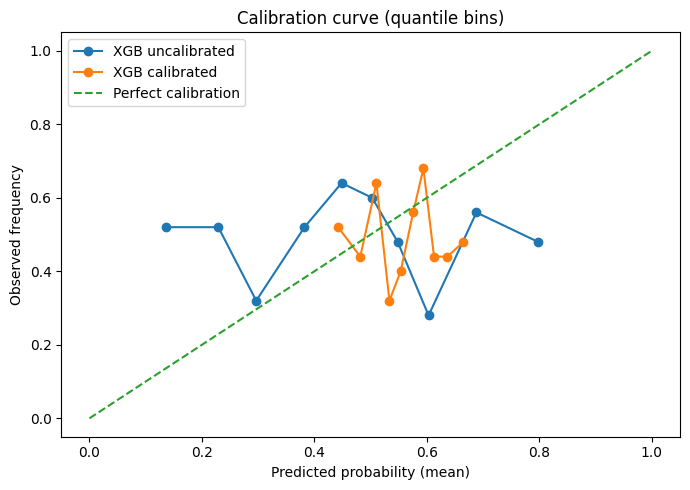

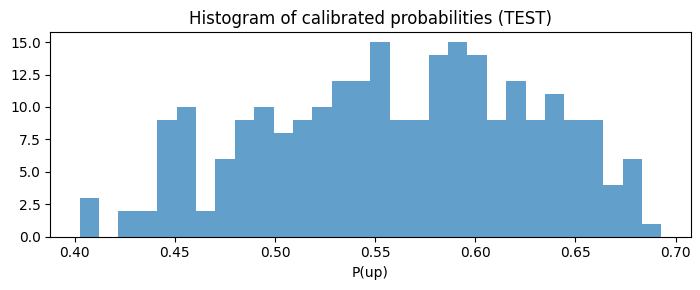

In [5]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# Calibration simple (Platt scaling / sigmoid)
xgb_cal = CalibratedClassifierCV(xgb_model, method="sigmoid", cv=3)
xgb_cal.fit(X_train, y_train)

proba_uncal = xgb_model.predict_proba(X_test)[:, 1]
proba_cal = xgb_cal.predict_proba(X_test)[:, 1]

print("Brier score XGB (uncal):", round(brier_score_loss(y_test, proba_uncal), 4))
print("Brier score XGB (cal)  :", round(brier_score_loss(y_test, proba_cal), 4))

# Courbe de calibration (quantile = bins équilibrés)
frac_uncal, mean_uncal = calibration_curve(y_test, proba_uncal, n_bins=10, strategy="quantile")
frac_cal, mean_cal = calibration_curve(y_test, proba_cal, n_bins=10, strategy="quantile")

plt.figure(figsize=(7, 5))
plt.plot(mean_uncal, frac_uncal, marker="o", label="XGB uncalibrated")
plt.plot(mean_cal, frac_cal, marker="o", label="XGB calibrated")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.title("Calibration curve (quantile bins)")
plt.xlabel("Predicted probability (mean)")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Bonus : on voit si tout est collé vers 0.5
plt.figure(figsize=(7, 3))
plt.hist(proba_cal, bins=30, alpha=0.7)
plt.title("Histogram of calibrated probabilities (TEST)")
plt.xlabel("P(up)")
plt.tight_layout()
plt.show()


In [6]:
from src.modeling import build_logreg_pipeline, build_random_forest, build_gradient_boosting

lr = build_logreg_pipeline()
rf = build_random_forest()
gb = build_gradient_boosting()

for m in [lr, rf, gb]:
    m.fit(X_train, y_train)

from src.evaluation import evaluate_classifier
evaluate_classifier(lr, X_train, y_train, X_test, y_test, name="LogReg (ext data)")
evaluate_classifier(rf, X_train, y_train, X_test, y_test, name="RandomForest (ext data)")
evaluate_classifier(gb, X_train, y_train, X_test, y_test, name="GradientBoosting (ext data)")


=== LogReg (ext data) ===
Accuracy: 0.468
ROC-AUC : 0.492
Confusion matrix:
 [[37 90]
 [43 80]]

Classification report:
               precision    recall  f1-score   support

           0      0.463     0.291     0.357       127
           1      0.471     0.650     0.546       123

    accuracy                          0.468       250
   macro avg      0.467     0.471     0.452       250
weighted avg      0.466     0.468     0.450       250

=== RandomForest (ext data) ===
Accuracy: 0.544
ROC-AUC : 0.534
Confusion matrix:
 [[64 63]
 [51 72]]

Classification report:
               precision    recall  f1-score   support

           0      0.557     0.504     0.529       127
           1      0.533     0.585     0.558       123

    accuracy                          0.544       250
   macro avg      0.545     0.545     0.544       250
weighted avg      0.545     0.544     0.543       250

=== GradientBoosting (ext data) ===
Accuracy: 0.476
ROC-AUC : 0.481
Confusion matrix:
 [[71 56]
 [

(0.476, 0.4807630753472889)

In [7]:
from sklearn.ensemble import VotingClassifier

# soft voting = moyenne pondérée des probas des modèles
ensemble = VotingClassifier(
    estimators=[
        ("lr", build_logreg_pipeline()),
        ("rf", build_random_forest()),
        ("gb", build_gradient_boosting()),
        ("xgb_cal", xgb_cal),
    ],
    voting="soft",
)

ensemble.fit(X_train, y_train)
evaluate_classifier(ensemble, X_train, y_train, X_test, y_test, name="Voting ensemble (with XGB calibrated)")


=== Voting ensemble (with XGB calibrated) ===
Accuracy: 0.516
ROC-AUC : 0.492
Confusion matrix:
 [[56 71]
 [50 73]]

Classification report:
               precision    recall  f1-score   support

           0      0.528     0.441     0.481       127
           1      0.507     0.593     0.547       123

    accuracy                          0.516       250
   macro avg      0.518     0.517     0.514       250
weighted avg      0.518     0.516     0.513       250



(0.516, 0.4922220088342616)

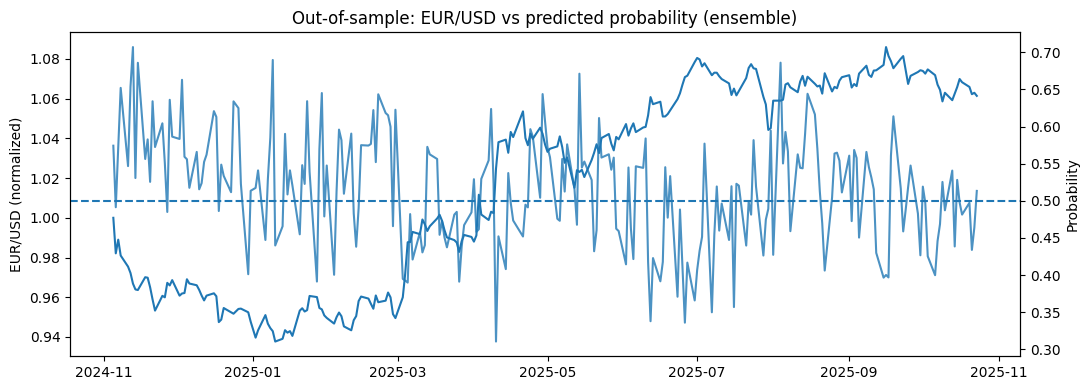

In [8]:
# On reprend les dates du segment test
cut = int(len(df_feat) * 0.8)
df_test = df_feat.iloc[cut:].copy().reset_index(drop=True)

proba_ens = ensemble.predict_proba(X_test)[:, 1]

fig, ax1 = plt.subplots(figsize=(11, 4))

# Prix EUR/USD (normalisé pour comparer visuellement)
price_norm = df_test["close"] / df_test["close"].iloc[0]
ax1.plot(df_test["date"], price_norm, label="EUR/USD close (normalized)")
ax1.set_ylabel("EUR/USD (normalized)")

# Proba sur un 2e axe
ax2 = ax1.twinx()
ax2.plot(df_test["date"], proba_ens, label="P(UP tomorrow) - ensemble", alpha=0.8)
ax2.axhline(0.5, linestyle="--")
ax2.set_ylabel("Probability")

ax1.set_title("Out-of-sample: EUR/USD vs predicted probability (ensemble)")
fig.tight_layout()
plt.show()


In [9]:
from src.inference import predict_date_ensemble

models = {
    "LogReg": lr,
    "RandomForest": rf,
    "GradientBoosting": gb,
    "XGBoost_cal": xgb_cal,
}

res = predict_date_ensemble(
    df_feat=df_feat,
    models=models,
    date=None,        # None = prend une date au hasard dans TEST
    test_size=0.2,
    random_state=42
)

print("=== Single-date prediction (random TEST date) ===")
print("Date:", res["date"])
print("Close(t):", res["close_t"])
print("Probabilités UP:", res["model_probas_up"])
print("Moyenne P(UP):", round(res["avg_proba_up"], 3), "=>", res["predicted_direction"])
print("Vérité terrain y_up:", res["actual_y_up"])


=== Single-date prediction (random TEST date) ===
Date: 2024-12-05 00:00:00
Close(t): 1.05871
Probabilités UP: {'LogReg': 0.5499690701506567, 'RandomForest': 0.49924458503444036, 'GradientBoosting': 0.5336276810891062, 'XGBoost_cal': 0.6409786194212576}
Moyenne P(UP): 0.556 => UP
Vérité terrain y_up: 0


In [ ]:
import ipywidgets as widgets
from IPython.display import display

df_ui = df_feat.sort_values("date").reset_index(drop=True)

n = len(df_ui)
cut = int(n * 0.8)
all_dates = df_ui["date"].dt.strftime("%Y-%m-%d").tolist()
test_dates = df_ui.iloc[cut:]["date"].dt.strftime("%Y-%m-%d").tolist()

scope_toggle = widgets.ToggleButtons(
    options=[("Test (20% fin)", "test"), ("Toutes dates", "all")],
    value="test",
    description="Scope:"
)

date_dd = widgets.Dropdown(options=test_dates, description="Date:", layout=widgets.Layout(width="260px"))
btn = widgets.Button(description="Prédire")
out = widgets.Output()

def update_dates(change=None):
    opts = test_dates if scope_toggle.value == "test" else all_dates
    date_dd.options = opts
    if len(opts) > 0:
        date_dd.value = opts[0]

scope_toggle.observe(update_dates, names="value")

def run_pred(_):
    with out:
        out.clear_output()

        d = pd.to_datetime(date_dd.value)
        row = df_ui[df_ui["date"] == d].iloc[0]

        X_row = row[FEATURE_COLS].values.reshape(1, -1)

        probas = {name: float(m.predict_proba(X_row)[0, 1]) for name, m in models.items()}
        p_avg = float(np.mean(list(probas.values())))
        direction = "UP" if p_avg >= 0.5 else "DOWN"

        # affichage valeurs externes si dispo
        def show_val(col):
            return float(row[col]) if (col in row.index and pd.notna(row[col])) else "NA"

        print("Date:", date_dd.value)
        print("EUR/USD close:", float(row["close"]))
        print("VIX:", show_val("vix"))
        print("DGS2:", show_val("dgs2"), "| DGS10:", show_val("dgs10"), "| Term spread:", show_val("term_spread"))
        print("DTWEXBGS:", show_val("dtwexbgs"), "| SP500:", show_val("sp500"))

        print("\nProbabilités UP:")
        for k, v in probas.items():
            print("-", k, ":", round(v, 3))

        print("\nMoyenne P(UP):", round(p_avg, 3), "=>", direction)
        print("Vérité terrain y_up:", int(row[TARGET_COL]))

btn.on_click(run_pred)

display(widgets.HBox([scope_toggle, date_dd, btn]))
display(out)


Output()